In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from pathlib import Path

import sys
sys.path.append("ComputeCanada/frequency_tagging")
from dfm import (
    f1_f2_data, 
    plot_power_spectrum,
    set_base_dir,
    analyze_rois,
    extract_im_products,
    store_data_in_dict,
    get_experiment_colour_codes,
    get_roi_colour_codes,
)

Cohort info

In [3]:
NORMAL_3T_SUB_IDS = ["000", "002", "003", "004", "005", "006", "007", "008", "009"]
NORMAL_3T = ("1_frequency_tagging", "3T", {key: [("entrain", [0.125, 0.2])] for key in NORMAL_3T_SUB_IDS})
NORMAL_7T_SUB_IDS = ["Pilot001", "Pilot009", "Pilot010", "Pilot011"]
NORMAL_7T = ("1_attention", "7T", {key: [("AttendAway", [0.125, 0.2])] for key in NORMAL_7T_SUB_IDS})
VARY_3T = (
    "1_frequency_tagging",
    "3T",
    {
        "020": [
            ("entrainA", [.125, .2]),
            ("entrainB", [.125, .175]),
            ("entrainC", [.125, .15]),
        ],
        "021": [
            ("entrainD", [.125, .2]),
            ("entrainE", [.15, .2]),
            ("entrainF", [.175, .2]),
        ],
    }
)
VARY_7T = (
    "1_frequency_tagging",
    "7T",
    {
        "020": [
            ("entrainA", [.125, .2]),
            ("entrainB", [.125, .175]),
            ("entrainC", [.125, .15]),
        ],
        "021": [
            ("entrainD", [.125, .2]),
            ("entrainE", [.15, .2]),
            ("entrainF", [.175, .2]),
        ],
    }
)

task_to_test_frequencies_map = {
    "entrain": [.125, .2],
    "control": [.125, .2],
    "AttendAway": [.125, .2],
    "entrainA": [.125, .2],
    "entrainD": [.125, .2],
    "entrainB": [.125, .175],
    "entrainC": [.125, .15],
    "entrainE": [.15, .2],
    "entrainF": [.175, .2],
}

def read_data(d):
    return d[0], d[1], d[2]

def save_bootstrapped_statistics(pkl_path, data_dict):
    import pickle
    with open(pkl_path, 'wb') as f:
        pickle.dump(data_dict, f)

def load_bootstrapped_statistics(pkl_path):
    import pickle
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

Save all statistics as pickle files

In [4]:
datadir = Path("/scratch/fastfmri")
n_permutations = 1000
n_bootstraps = 200
TR = .3
fos = [.8]
#pvals = ["uncp", "fdrp"]
pvals = ["uncp", "fdrp"]
nperseg = 570

# directories
fig_dir = Path(set_base_dir(f"./ComputeCanada/frequency_tagging/figures/dual_frequency_roi_psd"))
pickle_dir = Path(set_base_dir(f"/scratch/fastfmri/pickles"))

# data stores
frequency_grid = None # track, ensuring frequency_grid is consistent
#experiment_info = []
group_data_dict = None
# Loop over roi params: fos and pvals
for fo, pval in itertools.product(fos, pvals):

    # Loop over datasets
    dataset_ids = [NORMAL_3T, NORMAL_3T, NORMAL_7T, VARY_3T, VARY_7T]
    dataset_labels = ["NORMAL_3T", "NORMAL_3T_CONTROL", "NORMAL_7T", "VARY_3T", "VARY_7T"]
    for dataset_ix, (dataset_label, dataset_id) in enumerate(zip(dataset_labels, dataset_ids)):
        experiment_id, mri_id, sub_to_task_mapping = read_data(dataset_id)

        # Loop over subjects
        for sub_ix, (sub_id, sub_task_info) in enumerate(sub_to_task_mapping.items()):
            for task_ix, (roi_task_id, _) in enumerate(sub_task_info):


                if dataset_ix == 1:
                    task_id = "control"
                else:
                    task_id = roi_task_id

                test_frequencies = task_to_test_frequencies_map[task_id] # Load first order frequencies
                assert len(test_frequencies) == 2 and test_frequencies[0] < test_frequencies[1]
                
                pkl_handler = f1_f2_data(
                    datadir, 
                    n_bootstraps, 
                    sub_id, 
                    roi_task_id, 
                    test_frequencies[0], test_frequencies[1], 
                    task_id, 
                    experiment_id=experiment_id, 
                    mri_id=mri_id, 
                    fo=fo, 
                    pval=pval
                )
                
                # Update frequencies to get secondary, and tertiary IM frequencies
                im_test_frequencies_map = extract_im_products(test_frequencies[0], test_frequencies[1])
                im_test_frequencies = [v for v in im_test_frequencies_map.values()]

                info = (
                    f"Processing {dataset_label}, sub-{sub_id}, roi-task-id-{roi_task_id}, task-{task_id}, pval-{pval}, fo-{fo}\n"
                    f"   - Primary frequencies: {test_frequencies}\n"
                    f"   - Test frequencies: {im_test_frequencies}"
                )
                print(info)

                # Loop over rephase (enabling rephasing of timeseries with phase delay), frequency of ROIs (f1, f2, f1&f2)
                for rephase, f_type in itertools.product([True,False], ["f1", "f2", "f1f2"]):
                    if rephase and f_type == "f1f2":
                        n_intersected_rois = (pkl_handler.f_data['f1']['roi_coords'] * pkl_handler.f_data['f2']['roi_coords']).sum()
                        if n_intersected_rois.sum() == 0:
                            print(f"Skipping since 0 voxels were found at the intersection.")
                            continue
                        for rephase_with in ["f1", "f2"]:
                            pkl_path = pickle_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}-{rephase_with}_pval-{pval}_fo-{fo}.pkl"
                            png_out = fig_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}-{rephase_with}_pval-{pval}_fo-{fo}.png"
                            if png_out.exists() and pkl_path.exists():
                                data_dict = load_bootstrapped_statistics(pkl_path)
                            else:
                                frequency_grid, observed_statistics, observed_power_spectrum, null_power_spectrums, p_values, bootstrapped_statistics = analyze_rois(
                                    pkl_handler, 
                                    f_type, 
                                    im_test_frequencies, 
                                    n_bootstraps, 
                                    TR, 
                                    n_permutations=n_permutations, 
                                    nperseg=nperseg, 
                                    rephase=rephase, 
                                    rephase_with=rephase_with,
                                    frequency_grid=frequency_grid,
                                )
                                # Save pkl_path
                                data_dict = {
                                    "frequency_grid": frequency_grid, 
                                    "observed_power_spectrum": observed_power_spectrum, 
                                    "null_power_spectrums": null_power_spectrums, 
                                    "observed_statistics": observed_statistics, 
                                    "p_values": p_values, 
                                    "bootstrapped_statistics": bootstrapped_statistics,
                                }
                                save_bootstrapped_statistics(pkl_path, data_dict)
                                # Save png_out
                                plot_power_spectrum(frequency_grid, observed_power_spectrum, null_power_spectrums, n_permutations, test_frequencies, p_values, observed_statistics, add_im=True, sub_id=sub_id, roi_frequency=f_type, close_figure=True, png_out=png_out)
                            group_data_dict = store_data_in_dict(
                                dataset_label, sub_id,
                                roi_task_id, pval, fo, f_type,
                                rephase, rephase_with,
                                im_test_frequencies_map, data_dict,
                                n_bootstraps,
                                loaded_data_dict=group_data_dict
                            )
                    else:
                        pkl_path = pickle_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}_pval-{pval}_fo-{fo}.pkl"
                        png_out = fig_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}_pval-{pval}_fo-{fo}.png"
                        if png_out.exists() and pkl_path.exists():
                            data_dict = load_bootstrapped_statistics(pkl_path)
                        else:
                            frequency_grid, observed_statistics, observed_power_spectrum, null_power_spectrums, p_values, bootstrapped_statistics = analyze_rois(
                                pkl_handler, 
                                f_type, 
                                im_test_frequencies, 
                                n_bootstraps, 
                                TR, 
                                n_permutations=n_permutations, 
                                nperseg=nperseg, 
                                rephase=rephase,
                                rephase_with=None,
                                frequency_grid=frequency_grid,
                            )
                            # Save pkl_path
                            data_dict = {
                                "frequency_grid": frequency_grid, 
                                "observed_power_spectrum": observed_power_spectrum, 
                                "null_power_spectrums": null_power_spectrums, 
                                "observed_statistics": observed_statistics, 
                                "p_values": p_values, 
                                "bootstrapped_statistics": bootstrapped_statistics,
                            }
                            save_bootstrapped_statistics(pkl_path, data_dict)
                            # Save png_out
                            plot_power_spectrum(frequency_grid, observed_power_spectrum, null_power_spectrums, n_permutations, test_frequencies, p_values, observed_statistics, add_im=True, sub_id=sub_id, roi_frequency=f_type, close_figure=True, png_out=png_out)
                        group_data_dict = store_data_in_dict(
                            dataset_label, sub_id,
                            roi_task_id, pval, fo, f_type,
                            rephase, None,
                            im_test_frequencies_map, data_dict,
                            n_bootstraps,
                            loaded_data_dict=group_data_dict
                        )

df = pd.DataFrame(group_data_dict)

Processing NORMAL_3T, sub-000, roi-task-id-entrain, task-entrain, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - Test frequencies: [0.125, 0.2, 0.075, 0.325, 0.25, 0.4, 0.05, 0.275]
Processing NORMAL_3T, sub-002, roi-task-id-entrain, task-entrain, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - Test frequencies: [0.125, 0.2, 0.075, 0.325, 0.25, 0.4, 0.05, 0.275]
Processing NORMAL_3T, sub-003, roi-task-id-entrain, task-entrain, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - Test frequencies: [0.125, 0.2, 0.075, 0.325, 0.25, 0.4, 0.05, 0.275]
Processing NORMAL_3T, sub-004, roi-task-id-entrain, task-entrain, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - Test frequencies: [0.125, 0.2, 0.075, 0.325, 0.25, 0.4, 0.05, 0.275]
Processing NORMAL_3T, sub-005, roi-task-id-entrain, task-entrain, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - Test frequencies: [0.125, 0.2, 0.075, 0.325, 0.25, 0.4, 0.05, 0.275]
Processing NORM

In [6]:
df

,experiment_id,sub_id,roi_task_id,roi_pval,roi_fractional_overlap,roi_f_type,rephase,rephase_with,f1,power_f1,...,power_2f1-f2,pval_2f1-f2,bootstrap_power_2f1-f2,bootstrap_pval_2f1-f2,2f2-f1,power_2f2-f1,pval_2f2-f1,bootstrap_power_2f2-f1,bootstrap_pval_2f2-f1,power_spectrum
0,NORMAL_3T,000,entrain,uncp,0.8,f1,True,None,0.125,1.769083e-05,...,5.922766e-07,1.481920,0.000001,0.685,0.275,5.223051e-09,0.008765,2.456236e-08,0.000,"[1.2150182404452248e-09, 2.1957814321558137e-0..."
1,NORMAL_3T,000,entrain,uncp,0.8,f2,True,None,0.125,9.251703e-07,...,1.299721e-06,1.432232,0.000002,0.640,0.275,3.308148e-08,0.029622,1.207307e-07,0.005,"[4.535941950513236e-09, 3.137058375221238e-07,..."
2,NORMAL_3T,000,entrain,uncp,0.8,f1f2,True,f1,0.125,5.496238e-05,...,1.170746e-06,0.708178,0.000002,0.375,0.275,9.617746e-08,0.050069,1.591822e-07,0.000,"[8.667291245221195e-08, 8.115079119025679e-08,..."
3,NORMAL_3T,000,entrain,uncp,0.8,f1f2,True,f2,0.125,4.707743e-05,...,1.466954e-06,0.955111,0.000002,0.450,0.275,1.606687e-07,0.087150,2.102529e-07,0.000,"[1.467624947241049e-09, 1.7239020633370976e-07..."
4,NORMAL_3T,000,entrain,uncp,0.8,f1,False,None,0.125,1.752744e-05,...,6.328760e-07,1.131202,0.000001,0.525,0.275,6.966548e-09,0.006998,5.900773e-08,0.000,"[2.4592458345830835e-09, 2.9494993827704644e-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,VARY_7T,021,entrainF,fdrp,0.8,f1,True,None,0.175,1.365041e-04,...,4.337497e-06,0.991834,0.000005,0.255,0.225,2.061671e-07,0.009651,4.936047e-07,0.000,"[2.1476306382683647e-07, 5.367320045187737e-07..."
466,VARY_7T,021,entrainF,fdrp,0.8,f2,True,None,0.175,6.210326e-06,...,1.641986e-06,0.374094,0.000003,0.035,0.225,1.135043e-07,0.007881,4.865670e-07,0.000,"[1.27749117466128e-06, 3.654864566641543e-07, ..."
467,VARY_7T,021,entrainF,fdrp,0.8,f1,False,None,0.175,1.661563e-04,...,4.937002e-06,1.004799,0.000006,0.225,0.225,3.660260e-07,0.026383,6.755544e-07,0.000,"[1.026497976021082e-07, 6.609431084611485e-07,..."
468,VARY_7T,021,entrainF,fdrp,0.8,f2,False,None,0.175,6.055569e-06,...,1.730422e-06,0.328336,0.000003,0.010,0.225,1.519554e-07,0.004360,5.039223e-07,0.000,"[1.1449913218180037e-06, 3.0716421655081303e-0..."


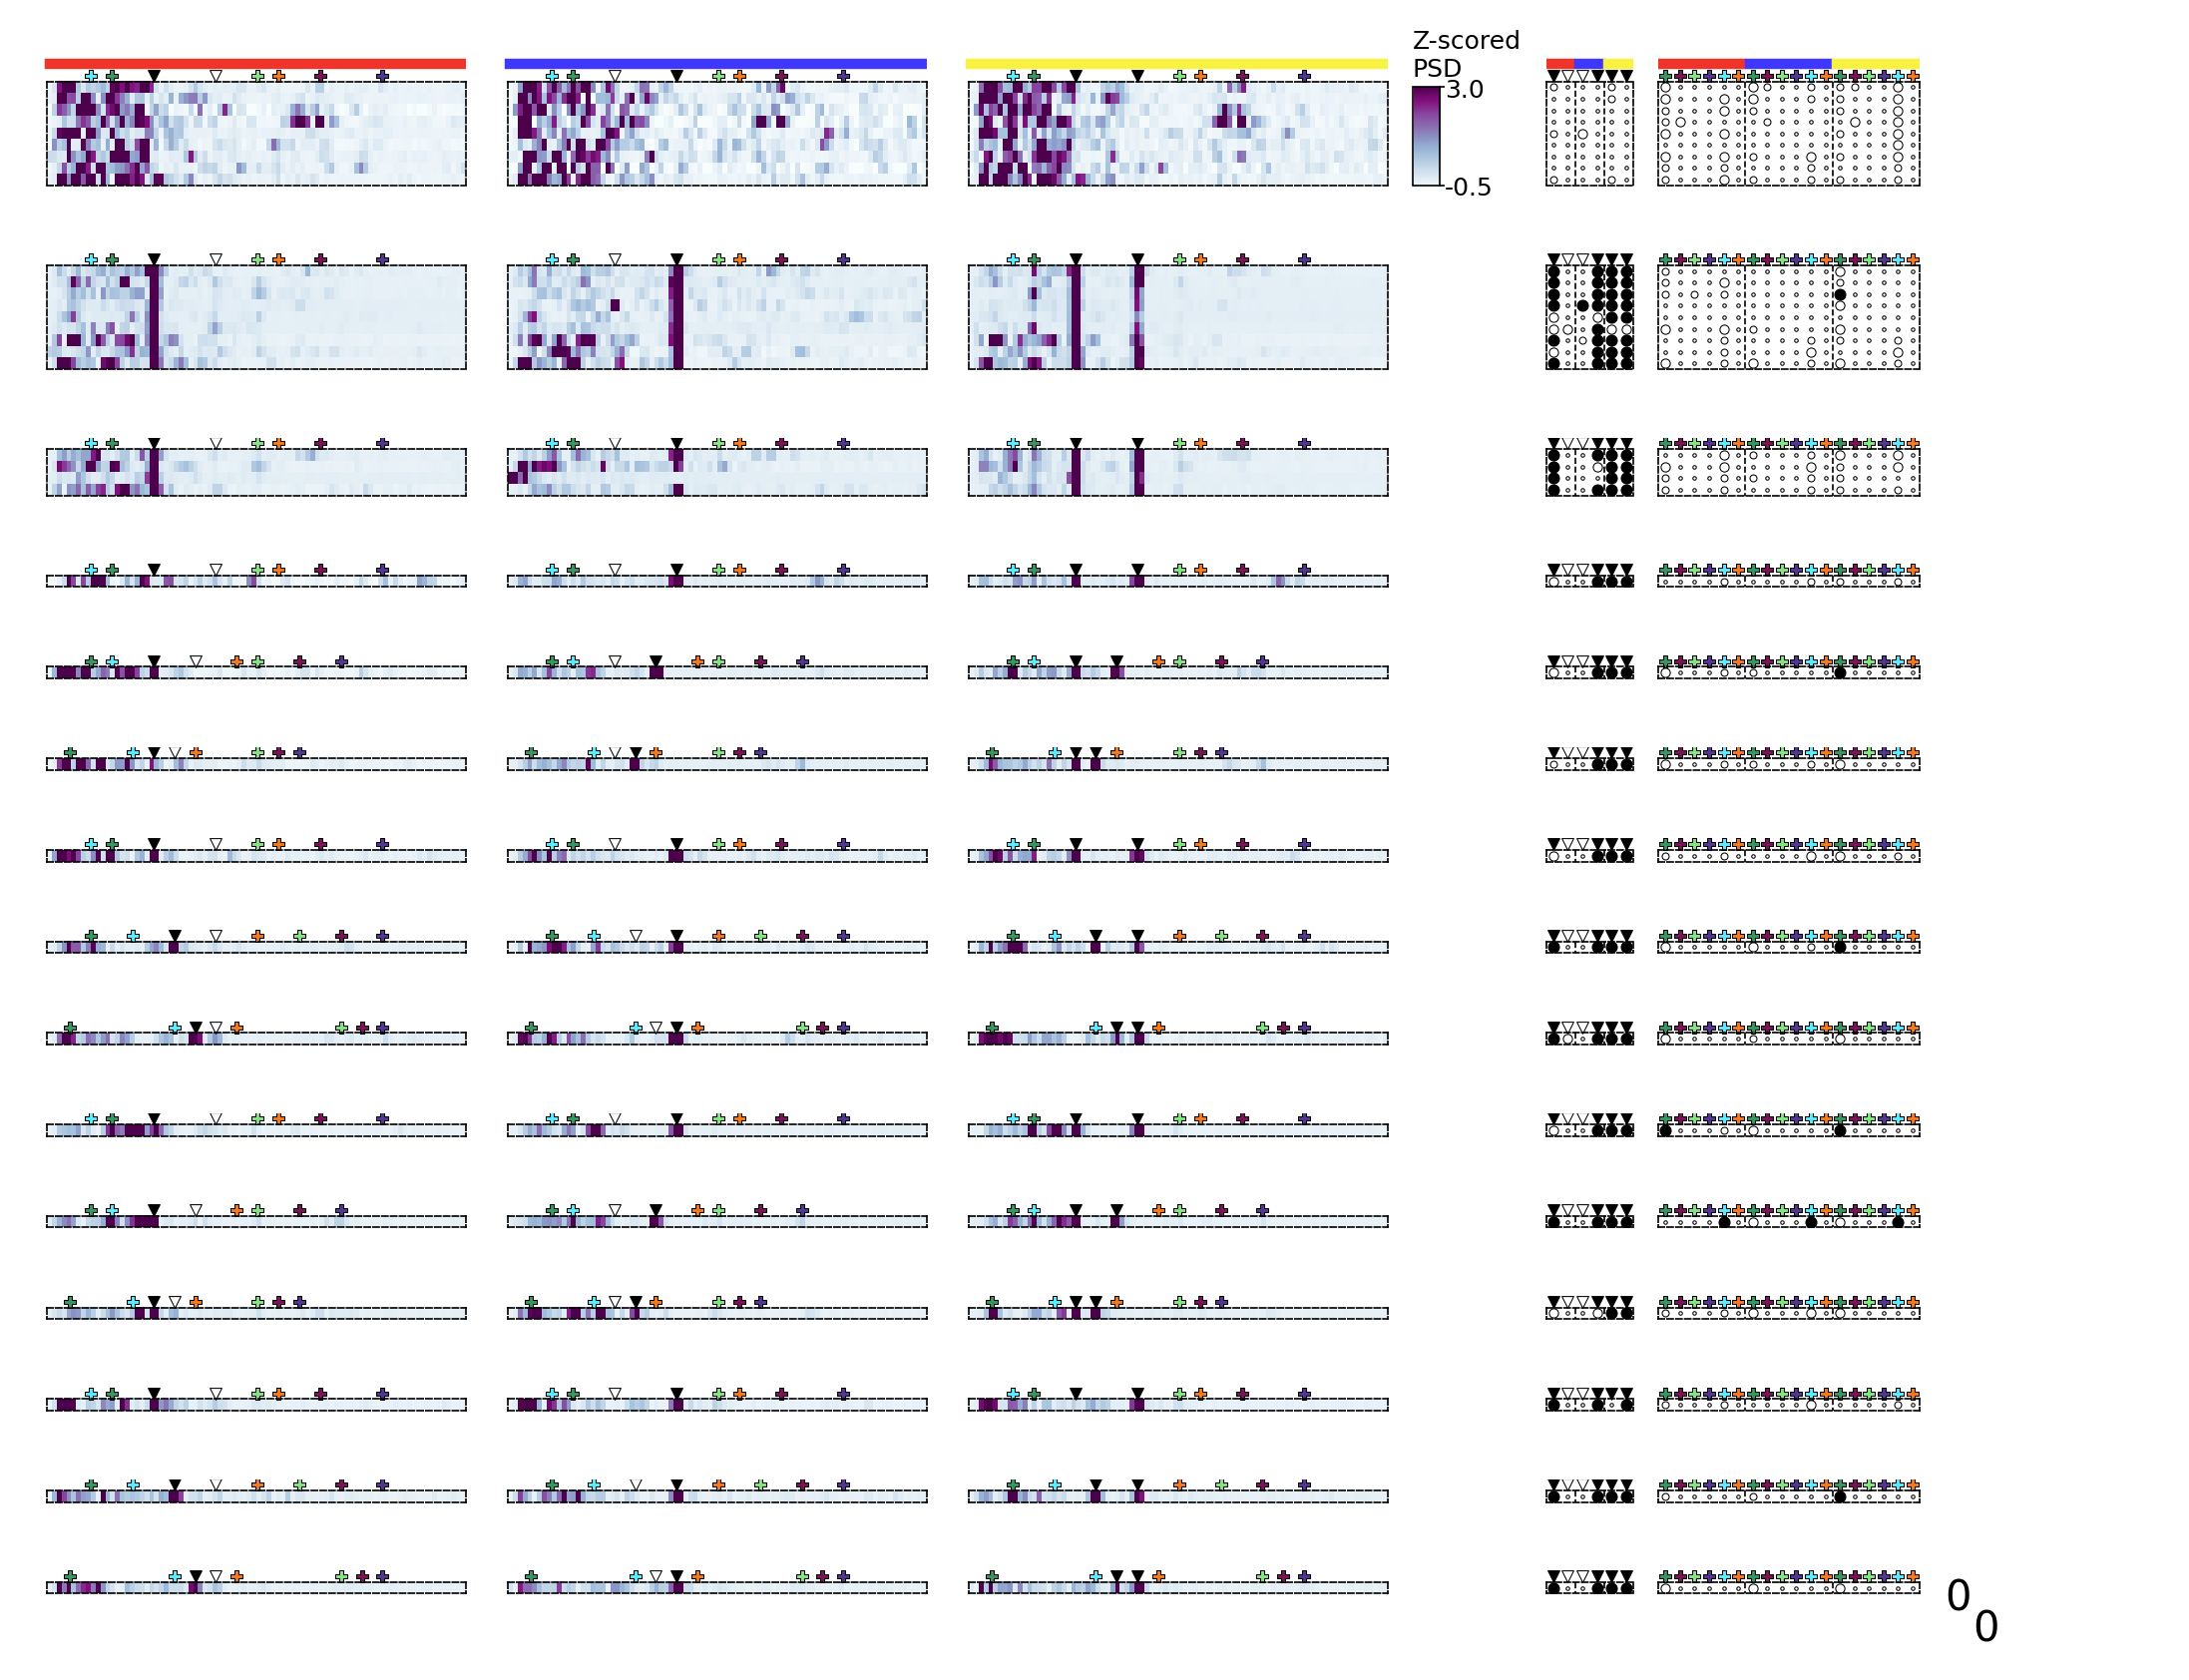

In [7]:
FONTSIZE = 6
DPI = 300
fig = plt.figure(
    layout="constrained",figsize=(7.2,5.5), # max 7.2
    dpi=DPI
)
ax_dict = fig.subplot_mosaic(
    [
        ["N3TC_f1", "N3TC_f2", "N3TC_f1f2", "LA", "N3TC_statistics", "N3TC_im_statistics","LB"],
        ["N3T_f1", "N3T_f2", "N3T_f1f2", ".", "N3T_statistics", "N3T_im_statistics","LB"],
        ["N7T_f1", "N7T_f2", "N7T_f1f2", ".", "N7T_statistics", "N7T_im_statistics","LB"],
        ["V3TA_f1", "V3TA_f2", "V3TA_f1f2", ".", "V3TA_statistics", "V3TA_im_statistics","LB"],
        ["V3TB_f1", "V3TB_f2", "V3TB_f1f2", ".", "V3TB_statistics", "V3TB_im_statistics","LB"],
        ["V3TC_f1", "V3TC_f2", "V3TC_f1f2", ".", "V3TC_statistics", "V3TC_im_statistics","LB"],
        ["V3TD_f1", "V3TD_f2", "V3TD_f1f2", ".", "V3TD_statistics", "V3TD_im_statistics","LB"],
        ["V3TE_f1", "V3TE_f2", "V3TE_f1f2", ".", "V3TE_statistics", "V3TE_im_statistics","LB"],
        ["V3TF_f1", "V3TF_f2", "V3TF_f1f2", ".", "V3TF_statistics", "V3TF_im_statistics","LB"],
        ["V7TA_f1", "V7TA_f2", "V7TA_f1f2", ".", "V7TA_statistics", "V7TA_im_statistics","LB"],
        ["V7TB_f1", "V7TB_f2", "V7TB_f1f2", ".", "V7TB_statistics", "V7TB_im_statistics","LB"],
        ["V7TC_f1", "V7TC_f2", "V7TC_f1f2", ".", "V7TC_statistics", "V7TC_im_statistics","LB"],
        ["V7TD_f1", "V7TD_f2", "V7TD_f1f2", ".", "V7TD_statistics", "V7TD_im_statistics","LB"],
        ["V7TE_f1", "V7TE_f2", "V7TE_f1f2", ".", "V7TE_statistics", "V7TE_im_statistics","LB"],
        ["V7TF_f1", "V7TF_f2", "V7TF_f1f2", ".", "V7TF_statistics", "V7TF_im_statistics","LB"],
    ],
    gridspec_kw={
        "height_ratios": [11,10,5]+6*[2]+6*[2],
        "width_ratios": [5,5,5,.3,1,3,2]
    }
)
experiment_c_dict = get_experiment_colour_codes()
roi_c_dict = get_roi_colour_codes()

roi_pval = "uncp"
roi_fractional_overlap = .8
rephase = False
rephase_with = "None"
dataset_labels = ["NORMAL_3T_CONTROL","NORMAL_3T","NORMAL_7T"] + 6*["VARY_3T"] + 6*["VARY_7T"]
roi_task_ids = ["entrain","entrain","AttendAway"] + 2 * [f"entrain{i}" for i in ["A","B","C","D","E","F"]]
ax_dataset_labels = ["N3TC","N3T","N7T"] + [f"V3T{i}" for i in ["A","B","C","D","E","F"]] + [f"V7T{i}" for i in ["A","B","C","D","E","F"]]
roi_f_types = ["f1","f2","f1f2"]
statistic_f_types = ["f1","f2"] # COLUMN B
im_statistic_f_types = [i for i in im_test_frequencies_map.keys() if i not in statistic_f_types] # COLUMN C
arrow_down_marker_s = 8
pval_marker_s = 7

# Threshold x-axis of all PSDs
frequency_grid = data_dict['frequency_grid']
xmax = (frequency_grid < .5).sum()

for ix, (dataset_label, roi_task_id, ax_dataset_label) in enumerate(zip(dataset_labels, roi_task_ids, ax_dataset_labels)):
    n_sub_ids = len(df[(df.experiment_id==dataset_label) & (df.roi_task_id==roi_task_id)].sub_id.unique())
    bootstrapped_pvals = np.zeros((n_sub_ids,len(roi_f_types)*len(statistic_f_types)))
    bootstrapped_power = np.zeros((n_sub_ids,len(roi_f_types)*len(statistic_f_types)))
    bootstrapped_im_pvals = np.zeros((n_sub_ids,len(roi_f_types)*len(im_statistic_f_types)))
    bootstrapped_im_power = np.zeros((n_sub_ids,len(roi_f_types)*len(im_statistic_f_types)))
    bootstrapped_col_ix = 0
    bootstrapped_im_col_ix = 0
    for roi_f_type in roi_f_types:
        ax_key = f"{ax_dataset_label}_{roi_f_type}"
        ax = ax_dict[ax_key]
        # Subset data frame
        subset_df = df[
            (df.experiment_id==dataset_label) &
            (df.roi_task_id==roi_task_id) &
            (df.roi_pval==roi_pval) &
            (df.roi_fractional_overlap==roi_fractional_overlap) &
            (df.roi_f_type==roi_f_type) &
            (df.rephase==rephase) &
            (~df.rephase_with.notnull())
        ]
        f1 = subset_df['f1'].unique()
        f2 = subset_df['f2'].unique()
        for f in [f1,f2]:
            if f.shape[0] != 1:
                raise ValueError(f"1 frequency expected: {f}")
        
        """COLUMN A"""
        # Stack single-subject PSDs
        psds = []
        for psd in subset_df.power_spectrum:
            psd = ( psd-psd.mean() ) / psd.std() # Z-score
            psds.append(psd)
        psds = np.vstack(psds)
        # Store statistics for COLUMN B figure
        for _f_type in statistic_f_types:
            for bootstrapped_row_ix, (_power, _pval) in enumerate(zip(subset_df[f"bootstrap_power_{_f_type}"],subset_df[f"bootstrap_pval_{_f_type}"])):
                bootstrapped_pvals[bootstrapped_row_ix,bootstrapped_col_ix] = _pval
                bootstrapped_power[bootstrapped_row_ix,bootstrapped_col_ix] = _power
            bootstrapped_col_ix+=1
        # Store statistics for COLUMN B figure
        for _f_type in im_statistic_f_types:
            for bootstrapped_row_ix, (_power, _pval) in enumerate(zip(subset_df[f"bootstrap_power_{_f_type}"],subset_df[f"bootstrap_pval_{_f_type}"])):
                bootstrapped_im_pvals[bootstrapped_row_ix,bootstrapped_im_col_ix] = _pval
                bootstrapped_im_power[bootstrapped_row_ix,bootstrapped_im_col_ix] = _power
            bootstrapped_im_col_ix+=1
        # Plot single-subject PSDs as heat map
        cropped_psds = psds[:,:xmax]
        if np.isnan(cropped_psds[0,0]):
            im = ax.imshow(np.zeros_like(cropped_psds)+.8,cmap="gray",interpolation="none",aspect="auto",vmin=0,vmax=1)
        else:
            im = ax.imshow(cropped_psds,cmap="BuPu",interpolation="none",aspect="auto",vmin=-.5,vmax=3)
        # Plot ROI annotations 
        # (f1,f2,f1&f2 - match color from figure panel)
        if ix == 0:
            ax.plot([0,xmax],[-2,-2],c=roi_c_dict[roi_f_type],linewidth=2.5)
        # (arrows)
        for _f_type in statistic_f_types:
            _f = subset_df[_f_type].unique()
            _c='white'
            if _f_type in roi_f_type:
                _c='k'
            ax.scatter(np.interp(_f, frequency_grid[:xmax], range(xmax)), -1., s=arrow_down_marker_s, c=_c, edgecolors='k',linewidths=0.25, marker='v')
        # (arrows) for im products
        for _f_type in im_statistic_f_types:
            _f = subset_df[_f_type].unique()
            ax.scatter(np.interp(_f, frequency_grid[:xmax], range(xmax)), -1., s=arrow_down_marker_s-1, c=roi_c_dict[_f_type], edgecolors='k',linewidths=0.25, marker='P')
        # Plot cohort annotations
        """
        for i in range(n_sub_ids):
            ax.scatter(-2.5, i, s=13.5, linewidths=0, marker='s', zorder=10, c=experiment_c_dict[dataset_label])
        """
        # Decorate
        ax.spines.top.set_position(("data",-.5))
        ax.spines.left.set_position(("data",-.5))
        if ix==0:
            ax.set_ylim(n_sub_ids-.5, -2.5)
        else:
            ax.set_ylim(n_sub_ids-.5, -1.5)
        for spine_pos in ['left', 'right']:
            ax.spines[spine_pos].set_bounds(-.5,n_sub_ids-.5)
        ax.set_xlim(-4,xmax-.5)
        for spine_pos in ['bottom', 'top']:
            ax.spines[spine_pos].set_bounds(-.5,xmax-.5)
        
        yticklabels = [i for i in subset_df.sub_id]
        yticks = [i for i in range(len(yticklabels))]
        if ax_key.endswith("_f1"):
            #ax.set_yticks(yticks)
            #ax.set_yticklabels(yticklabels,fontsize=FONTSIZE)
            ax.set_yticks([])
            #ax.set_yticklabels(yticklabels,fontsize=FONTSIZE)
        else:
            ax.set_yticks([])
        ax.set_xticks([])
        ax.tick_params(axis="x", length=0)
        ax.tick_params(axis="y", length=4., width=.2)
        for i in ("top", "right", "bottom", "left"):
            ax.spines[i].set_linestyle('dashed')
            ax.spines[i].set_linewidth(.4)

    """COLUMN B"""
    ax = ax_dict[f"{ax_dataset_label}_statistics"]
    im = ax.imshow(np.zeros_like(bootstrapped_pvals),cmap="binary",interpolation="none",aspect="auto",vmin=0,vmax=1)
    # colour code ROI
    if ix == 0:
        ax.plot([0-.2,1.2],[-2,-2],c=roi_c_dict["f1"],linewidth=2.5)
        ax.plot([1.8,3.2],[-2,-2],c=roi_c_dict["f2"],linewidth=2.5)
        ax.plot([3.8,5.2],[-2,-2],c=roi_c_dict["f1f2"],linewidth=2.5)
    # indicated ROI frequency
    ax.scatter(0, -1., s=arrow_down_marker_s, c='k', edgecolors='k',linewidths=0.25, marker='v')
    ax.scatter(1, -1., s=arrow_down_marker_s, c='white', edgecolors='k',linewidths=0.25, marker='v')
    ax.scatter(2, -1., s=arrow_down_marker_s, c='white', edgecolors='k',linewidths=0.25, marker='v')
    ax.scatter(3, -1., s=arrow_down_marker_s, c='k', edgecolors='k',linewidths=0.25, marker='v')
    ax.scatter(4, -1., s=arrow_down_marker_s, c='k', edgecolors='k',linewidths=0.25, marker='v')
    ax.scatter(5, -1., s=arrow_down_marker_s, c='k', edgecolors='k',linewidths=0.25, marker='v')
    # Plot pvalue %
    xdim_bootstrap, ydim_bootstrap = bootstrapped_pvals.shape
    for _x in range(xdim_bootstrap):
        for _y in range(ydim_bootstrap):
            c='white'
            if np.isnan(bootstrapped_power[_x,_y]):
                ax.scatter(_y,_x,s=3,marker='x',c='k',linewidths=0.25)
                continue
            if bootstrapped_pvals[_x,_y] > 1:
                raise ValueError()
            elif bootstrapped_pvals[_x,_y]==1.:
                s=pval_marker_s
                c='k'
            elif bootstrapped_pvals[_x,_y]>.8:
                s=pval_marker_s*.7
            elif bootstrapped_pvals[_x,_y]>.6:
                s=pval_marker_s*.4
            else:
                s=pval_marker_s*.1
            ax.scatter(_y,_x,s=s,c=c,edgecolors='k',linewidths=0.25)
    # Decorate
    ax.spines.top.set_position(("data",-.5))
    ax.spines.left.set_position(("data",-.5))
    if ix==0:
        ax.set_ylim(n_sub_ids-.5, -2.5)
    else:
        ax.set_ylim(n_sub_ids-.5, -1.5)
    for spine_pos in ['left', 'right']:
        ax.spines[spine_pos].set_bounds(-.5,n_sub_ids-.5)
    # Add pseudo-spines 
    ax.plot([1.5,1.5],[-.5,n_sub_ids-.5],linestyle='dashed',lw=.4,c='k')
    ax.plot([3.5,3.5],[-.5,n_sub_ids-.5],linestyle='dashed',lw=.4,c='k')

    #ax.set_xlim(-4,len(f_type_order)-.5)
    #for spine_pos in ['bottom', 'top']:
        #ax.spines[spine_pos].set_bounds(-.5,xmax-.5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis="x", length=0)
    ax.tick_params(axis="y", length=2., width=.2)
    for i in ("top", "right", "bottom", "left"):
        ax.spines[i].set_linestyle('dashed')
        ax.spines[i].set_linewidth(.4)

    """COLUMN C"""
    ax = ax_dict[f"{ax_dataset_label}_im_statistics"]
    im = ax.imshow(np.zeros_like(bootstrapped_im_pvals),cmap="binary",interpolation="none",aspect="auto",vmin=0,vmax=1)
    # colour code ROI
    if ix == 0:
        ax.plot([0-.2,5.2],[-2,-2],c=roi_c_dict["f1"],linewidth=2.5)
        ax.plot([5.8,11.2],[-2,-2],c=roi_c_dict["f2"],linewidth=2.5)
        ax.plot([11.8,17.2],[-2,-2],c=roi_c_dict["f1f2"],linewidth=2.5)
    # indicated ROI frequency
    counter = 0
    for i in range(len(roi_f_types)):
        for _f_type in im_statistic_f_types:
            ax.scatter(counter, -1., s=arrow_down_marker_s-1, c=roi_c_dict[_f_type], edgecolors='k',linewidths=0.25, marker='P')
            counter+=1
    # Plot pvalue %
    xdim_bootstrap, ydim_bootstrap = bootstrapped_im_pvals.shape
    for _x in range(xdim_bootstrap):
        for _y in range(ydim_bootstrap):
            c='white'
            if np.isnan(bootstrapped_im_power[_x,_y]):
                ax.scatter(_y,_x,s=3,marker='x',c='k',linewidths=0.25)
                continue
            if bootstrapped_im_pvals[_x,_y] > 1:
                raise ValueError()
            elif bootstrapped_im_pvals[_x,_y]==1.:
                s=pval_marker_s
                c='k'
            elif bootstrapped_im_pvals[_x,_y]>.8:
                s=pval_marker_s*.7
            elif bootstrapped_im_pvals[_x,_y]>.6:
                s=pval_marker_s*.4
            else:
                s=pval_marker_s*.1
            ax.scatter(_y,_x,s=s,c=c,edgecolors='k',linewidths=0.25)
    # Decorate
    ax.spines.top.set_position(("data",-.5))
    ax.spines.left.set_position(("data",-.5))
    if ix==0:
        ax.set_ylim(n_sub_ids-.5, -2.5)
    else:
        ax.set_ylim(n_sub_ids-.5, -1.5)
    for spine_pos in ['left', 'right']:
        ax.spines[spine_pos].set_bounds(-.5,n_sub_ids-.5)
    # Add pseudo-spines 
    ax.plot([5.5,5.5],[-.5,n_sub_ids-.5],linestyle='dashed',lw=.4,c='k')
    ax.plot([11.5,11.5],[-.5,n_sub_ids-.5],linestyle='dashed',lw=.4,c='k')

    #ax.set_xlim(-4,len(f_type_order)-.5)
    #for spine_pos in ['bottom', 'top']:
        #ax.spines[spine_pos].set_bounds(-.5,xmax-.5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis="x", length=0)
    ax.tick_params(axis="y", length=2., width=.2)
    for i in ("top", "right", "bottom", "left"):
        ax.spines[i].set_linestyle('dashed')
        ax.spines[i].set_linewidth(.4)

# Cmap 
ax = ax_dict["LA"]
n_sub_ids = 9
cmap_as_imshow = np.linspace(0,10,10000).reshape(100,100)
im = ax.imshow(cmap_as_imshow,cmap="BuPu_r",interpolation="none",aspect="auto")
# Decorate
ratio = 100/n_sub_ids
ax.spines.top.set_position(("data",0))
ax.spines.left.set_position(("data",-.5*ratio))
ax.set_ylim((n_sub_ids*ratio)-(.5*ratio), -2.5*ratio)
for spine_pos in ['left', 'right']:
    ax.spines[spine_pos].set_bounds(0*ratio,n_sub_ids*ratio-.5*ratio)

ax.set_yticks([0,ax.get_ylim()[0]])
ax.set_yticklabels([f"{3:.1f}",f"{-.5:.1f}"], fontsize=FONTSIZE)
ax.yaxis.tick_right()
ax.tick_params(axis="y", length=1.2, direction="out", width=.4,pad=0)
ax.set_xticks([0])
ax.set_xticklabels(ax.get_xticklabels(),fontsize=0,c='white')
ax.tick_params(axis="x", length=0)
for i in ("top", "right", "bottom", "left"):
    ax.spines[i].set_linestyle('-')
    ax.spines[i].set_linewidth(.4)
ax.text(-.5*ratio,-1*ratio,"Z-scored\nPSD",fontsize=FONTSIZE)

# Legend
ax = ax_dict["LB"]
for i in ("top", "right", "bottom", "left"):
    ax.spines[i].set_visible(False)
ax.set_xticks([0])
ax.set_yticks([0])
ax.tick_params(axis="both", length=0)

#_ = ax_dict['N3TC_f1'].set_title("$f_1$", fontsize=FONTSIZE+2)
#_ = ax_dict['N3TC_f2'].set_title("$f_2$", fontsize=FONTSIZE+2)
#_ = ax_dict['N3TC_f1f2'].set_title("$f_1 \cap f_2$", fontsize=FONTSIZE+2)

In [18]:
fig.savefig("test.svg",dpi=fig.dpi)
fig.savefig("test.png",dpi=fig.dpi)